In [1]:
import warnings

warnings.filterwarnings("ignore")
import torch

import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
from pathlib import Path

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = 'D:/software/R/R-4.3.2'
os.environ['R_USER'] = 'D:/software/anaconda/anaconda3/envs/pt20cu118/Lib/site-packages/rpy2'
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# %%
import SpaCross as TOOLS


def load_data(section_ids, k_cutoff, rad_cutoff, mode, n_top_genes):
    Batch_list = []
    for idxxx, section_id in enumerate(section_ids):
        print(section_id)
        input_dir = os.path.join('D:\\project\\datasets\\DLPFC\\', section_id)
        adata = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5',
                               load_images=True)
        adata.var_names_make_unique(join="++")
        adata.obs['slice_id'] = idxxx

        # read the annotation
        Ann_df = pd.read_csv(os.path.join(input_dir, section_id + '_truth.txt'), sep='\t', header=None, index_col=0)
        Ann_df.columns = ['Ground Truth']
        Ann_df[Ann_df.isna()] = "unknown"
        adata.obs['layer_guess'] = Ann_df.loc[adata.obs_names, 'Ground Truth'].astype('category')
        # make spot name unique
        adata.obs_names = [x + '_' + section_id for x in adata.obs_names]
        adata.var_names_make_unique()
        adata.layers['count'] = adata.X.toarray()
        sc.pp.filter_genes(adata, min_cells=50)
        sc.pp.filter_genes(adata, min_counts=10)
        sc.pp.normalize_total(adata, target_sum=1e6)
        sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=n_top_genes)
        adata = adata[:, adata.var['highly_variable'] == True]
        sc.pp.scale(adata)
        adata = adata[:, adata.var['highly_variable']]
        Batch_list.append(adata)

    Batch_list = TOOLS.align_spots(Batch_list, method='icp', plot=True)
    adata, edge_index = TOOLS.graph_construction3D(Batch_list, section_ids=section_ids, k_cutoff=k_cutoff,rad_cutoff=rad_cutoff, mode=mode, slice_dist_micron=[10, 10, 10])
    adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
    adata.obsm['X_pca'] = adata_X
    return adata, edge_index


In [2]:
with open('../Config/DLPFC.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

151673
151674
151675
151676


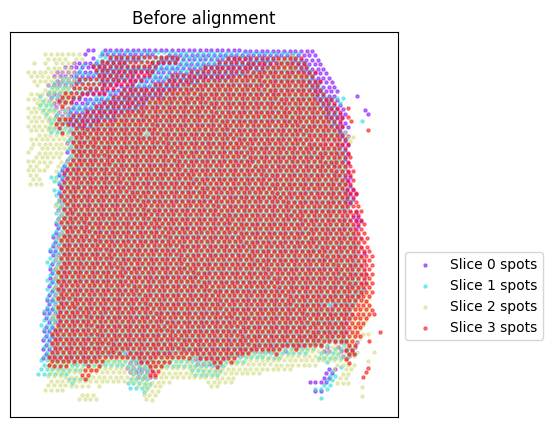

Using the Iterative Closest Point algorithm for alignemnt.
Detecting edges...
Aligning edges...


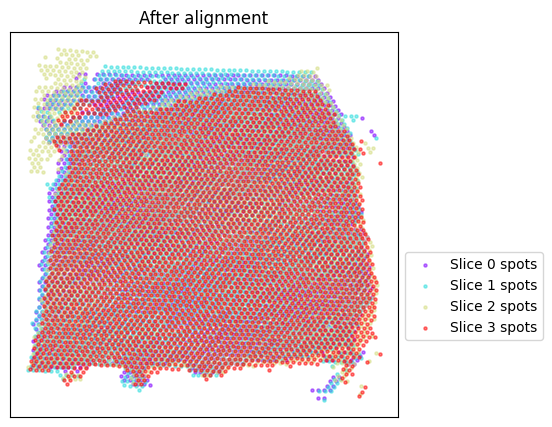

Start building a graph...
Radius for graph connection is 205.5000.
The graph contains 172368 edges, 14364 cells.
12.0000 neighbors per cell on average.


In [3]:
slices_list = ['151673', '151674', '151675', '151676']
adata, edge_index = load_data(slices_list, k_cutoff=12, rad_cutoff=None, mode='KNN', n_top_genes=5000)

In [4]:
num_clusters = 7
clusType = "mclust"

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = TOOLS.SC_pipeline(adata, edge_index=edge_index, num_clusters=num_clusters, device=device, config=config, imputation=False)
# %%
net.trian()
# %%
enc_rep, recon = net.process()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon


Epoch 299 total loss=1.485 recon loss=0.905 mean loss=0.413 tri loss=1.363: 100%|██████████| 300/300 [00:43<00:00,  6.93it/s]


In [6]:
# %%
adata.obs[clusType] = TOOLS.clustering(z=enc_rep, n_clust=num_clusters, num_seed=1, method=clusType)
# adata.obs[clusType] = TOOLS.refine_label(adata, 30, key=clusType)
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = ari_score(sub_adata.obs['layer_guess'], sub_adata.obs[clusType])

for name in slices_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['slice_name'] == name]
    ARI, ACC, DIS = TOOLS.get_metrics(sub_adata_tmp, 'layer_guess', "mclust")
    print(f"{name} ARI: {round(ARI, 4)} ACC: {round(ACC, 4)} DIS: {round(DIS, 4)}")

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
151673 ARI: 0.5495 ACC: 0.6937 DIS: 0.041
151674 ARI: 0.605 ACC: 0.7285 DIS: 0.0402
151675 ARI: 0.559 ACC: 0.6795 DIS: 0.0394
151676 ARI: 0.535 ACC: 0.6604 DIS: 0.0415


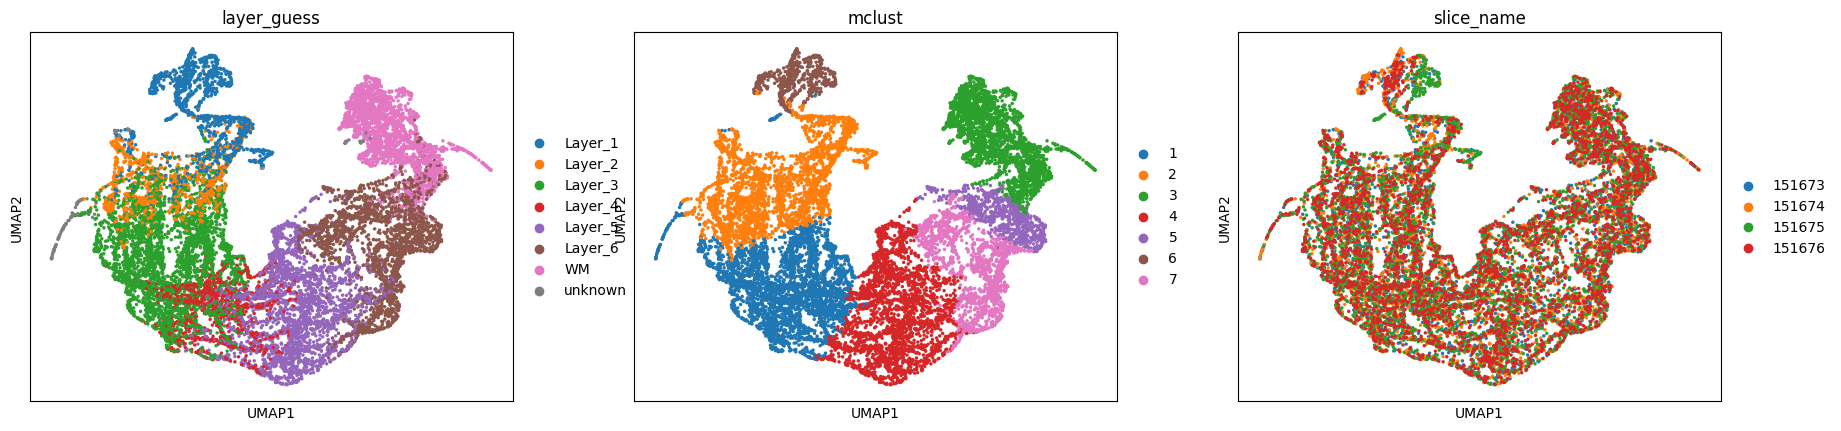

In [7]:
# %%
sc.pp.neighbors(adata, use_rep='latent', metric='cosine')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['layer_guess', clusType, 'slice_name'], show=True, size=25, save=False)

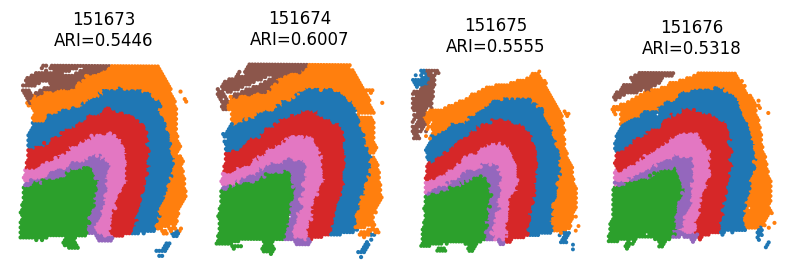

In [8]:
from matplotlib import pyplot as plt

spot_size = 200
title_size = 12
fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for idx, name in enumerate(slices_list):
    sub_adata = adata[adata.obs['slice_name'] == name]
    sub_adata.obs["mclust"] = TOOLS.refine_label(sub_adata, 5, key="mclust")
    sub_adata_tmp = sub_adata[~pd.isnull(sub_adata.obs['layer_guess'])]
    ARI, ACC, DIS = TOOLS.get_metrics(sub_adata_tmp, 'layer_guess', "mclust")
    _sc_ = sc.pl.spatial(sub_adata, img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[idx], frameon=False,
                      spot_size=spot_size)
    _sc_[0].set_title(name + "\nARI=" + str(round(ARI, 4)), size=title_size)
plt.show()